In [521]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Data Preparations

In [3]:
train_df = pd.read_csv('TaiwanPricing_Train.csv')
train_df.columns

Index(['ID', 'Date', 'Age', 'DisttoMRT', 'NumConvStores', 'Lat', 'Long',
       'Price', 'Year', 'Month'],
      dtype='object')

In [3]:
train_df.head()

,ID,Date,Age,DisttoMRT,NumConvStores,Lat,Long,Price,Year,Month
0,20,2012.666667,1.5,23.38284,7,24.96772,121.54102,47.7,2012,9
1,276,2012.666667,1.5,23.38284,7,24.96772,121.54102,49.7,2012,9
2,161,2012.916667,3.5,49.66105,8,24.95836,121.53756,57.8,2012,12
3,378,2013.333333,3.9,49.66105,8,24.95836,121.53756,56.8,2013,5
4,58,2012.916667,3.5,56.47425,7,24.95744,121.53711,53.5,2012,12


## Problem 1

### Part 1

For the training data, create a plot that shows the relationship between the latitude and longitude of the property and its price.  There are many ways to accomplish this: you can try creating a 3D scatter plot, but I think there are more clever ways to accomplish this in 2 dimensions using color, point size, or smoothers to create a contour plot.

What relationships do you see?  Do you think that this relationship is easily captured using a linear model?  Why or why not?

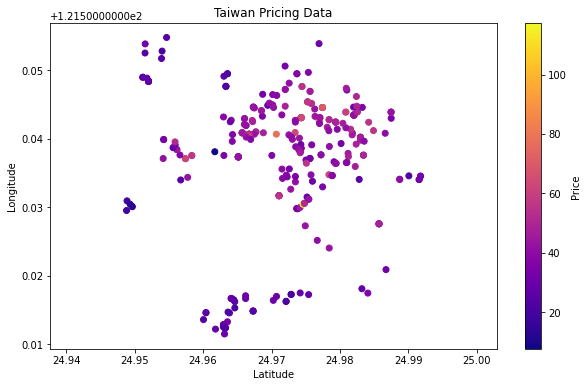

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_title('Taiwan Pricing Data')
ax.axis('equal')
fig.colorbar(ax.scatter(train_df['Lat'], train_df['Long'], c=train_df['Price'], cmap='plasma'),
 ax=ax, label='Price')
plt.show()


From the scatter plot above, we can somewhat see that price is positively correlated with both latitude and longitude. However, we cannot make sure if the relationship is linear because the data points at the center of the middle "cluster" seem to show higher prices (yellow-ish data points) than the points at the edges of the "cluster". Therefore, based on the training data, a linear model cannot capture this relationship.


### Part 2

Using the latitude, longitude, and price included in the training data set, compute the mean squared error of the predictions made by the model **for the in-sample data** for $K$-nearest neighbors for 1 through 20 nearest neighbors.  Plot the mean squared error (MSE) against the number of nearest neighbors.

Recall that the in-sample MSE always decreases as the flexibility and complexity of the model increases.  What is the least complex value of $k$ for the $K$-nearest neighbors algorithm?  In a sentence or two, explain why this is the case.

In [43]:
# MSE
def get_MSE(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

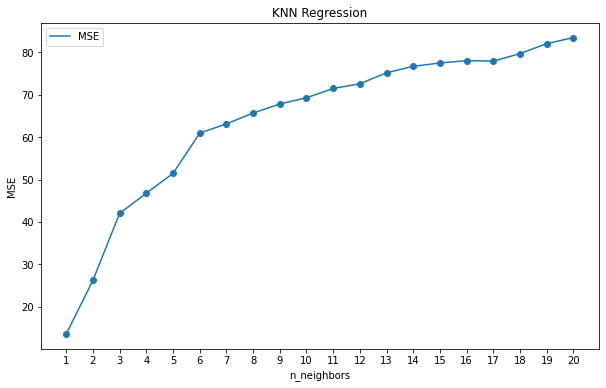

In [510]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
x_train = train_df[['Lat', 'Long']]
y_train = train_df['Price']
clf = [KNeighborsRegressor(n_neighbors=i) for i in range(1, 21)]
y_predict = [clf[i].fit(x_train, y_train).predict(x_train) for i in range(len(clf))]
knn_MSE = [get_MSE(y_pred=y_predict[i], y_true=y_train) for i in range(20)]
fig, ax = plt.subplots(figsize=(10, 6))
pd.DataFrame({'n_neighbors': range(1, 21), 'MSE': knn_MSE}).plot(x='n_neighbors', y='MSE', kind='line', ax=ax)
ax.scatter(range(1, 21), knn_MSE)
ax.set_xlabel('n_neighbors')
ax.set_ylabel('MSE')
ax.set_title('KNN Regression')
ax.set_xticks(range(1, 21))

From the line plot above, we can see that the in-sample MSE increases as the number of nearest neighbors increases. The least complex value of $k$ is 20 because the in-sample MSE is the highest for 20 nearest neighbor. This makes sense because when $k=20$, the model is the most flexible and the least prone to variance in data.

### Part 3

Write a function called `knn_reg_kfold` that takes five arguments: 1) `x` - a $N \times P$ matrix of predictors, 2) `y` - a $N$ vector of outcomes, 3) `k` - an integer value for the number of neighbors to take, 4) `folds` - an integer value for the number of folds in the data, and 5) `seed` - an integer value that will define the seed that dictates how the folds are divided.  Your function should return the $K$-fold cross validation estimate of the expected mean squared prediction error for a new observation.

**The implementation of $K$-nearest neighbors that you choose may have a built in $K$-fold cross validation method.  For this problem, please construct the folds and estimates yourself!**

Using `knn_reg_kfold`, set the numer of folds to 2,5,10,20, and $N$ (LOOCV) and estimate the cross validation estimate of the mean squared prediction error.  Plot your estimate of the expected prediction error against the number of nearest neighbors for each number of folds on the same graph.  Does the number of neighbors with the lowest $K$-fold prediction error remain the same/similar across all the number of folds?

Note: Leave one out cross validation should be relatively quick given this data size and the speed of the KNN algorithms in the recommended packages.  If you find that your function is really dragging, check that your implementation is using a compiled sort and search.  If that doesn't work, reach out and I can try to provide some advice.

In [137]:
import random
def knn_reg_kfold(x_train, y_train, k, folds, seed):

    if not (isinstance(x_train, np.ndarray) and isinstance(y_train, np.ndarray)):
        raise TypeError('x_train and y_train must be numpy arrays')
    if not (isinstance(folds, int) and folds > 0 and isinstance(seed, int)):
        raise TypeError('folds and seed must be integers greater than 0')
    if folds > len(x_train):
        raise ValueError('folds must be less than or equal to the number of rows in x_train')
    if len(x_train) != len(y_train):
        raise ValueError('x_train and y_train must be the same length')

    train_full = np.column_stack((x_train, y_train))
    np.random.seed(seed)
    np.random.shuffle(train_full)
    x_train = train_full[:, :-1]
    y_train = train_full[:, -1]

    scores = []

    foldSize = int(len(x_train) / folds)
    if folds == 1:
        return
    for i in range(folds):
        x_train_cv = np.delete(x_train, range(i * foldSize, (i + 1) * foldSize), axis=0)
        y_train_cv = np.delete(y_train, range(i * foldSize, (i + 1) * foldSize), axis=0)
        knn = KNeighborsRegressor(n_neighbors=k)
        knn.fit(x_train_cv, y_train_cv)
        y_pred = knn.predict(x_train[i * foldSize: (i + 1) * foldSize])
        scores.append(get_MSE(y_true=y_train[i * foldSize: (i + 1) * foldSize], y_pred=y_pred))
    
    return np.mean(scores)

        

    

In [196]:
k_folds = [2,5,10,20, len(x_train)]
k_nn = list(range(1, 21))
# seed = 12345
knn_fold_df = pd.DataFrame([[knn_reg_kfold(x_train.to_numpy(), y_train.to_numpy(), k=j, folds=i, seed=12345), i, j] for i in k_folds for j in k_nn], columns=['MSE', 'folds', 'k'])

In [198]:
knn_fold_df.head()

,MSE,folds,k
0,146.877293,2,1
1,106.188240,2,2
2,93.993581,2,3
3,91.810713,2,4
4,94.551284,2,5


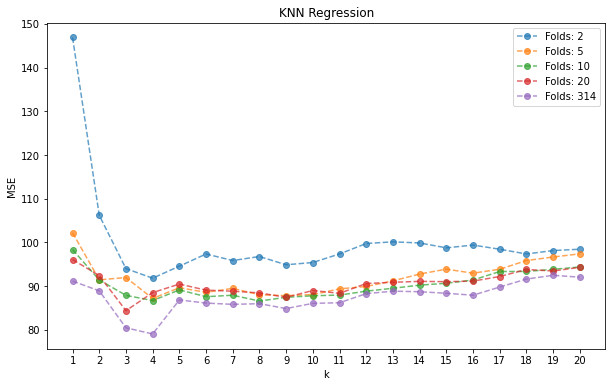

In [197]:
fig, ax = plt.subplots(figsize=(10, 6))

for i in k_folds:
    knn_fold_df[knn_fold_df['folds'] == i]\
        .plot(x='k', y='MSE', kind='line', ax=ax, label="Folds: {}".format(i), alpha=0.7, style='--o')
ax.set_xlabel('k')
ax.set_ylabel('MSE')
ax.set_title('KNN Regression')
ax.set_xticks(range(1, 21))



From the line plot above, we can see that the number of folds does affect the expected MSE for a given number of nearest neighbors. The prediction error for 2 folds has the largest variance given 1-20 nearest neighbors, while other folds with a higher number tend to be more stable. However, we can still see that across all folds, the expected MSE is the lowest when $K=4$ for K nearest neighbors.

### Part 4

Create the plot in Part 2 again using different seeds for your validation set splits. Do the results change? What does this say about the relationship between the estimated expected prediction error and your choice of splits?



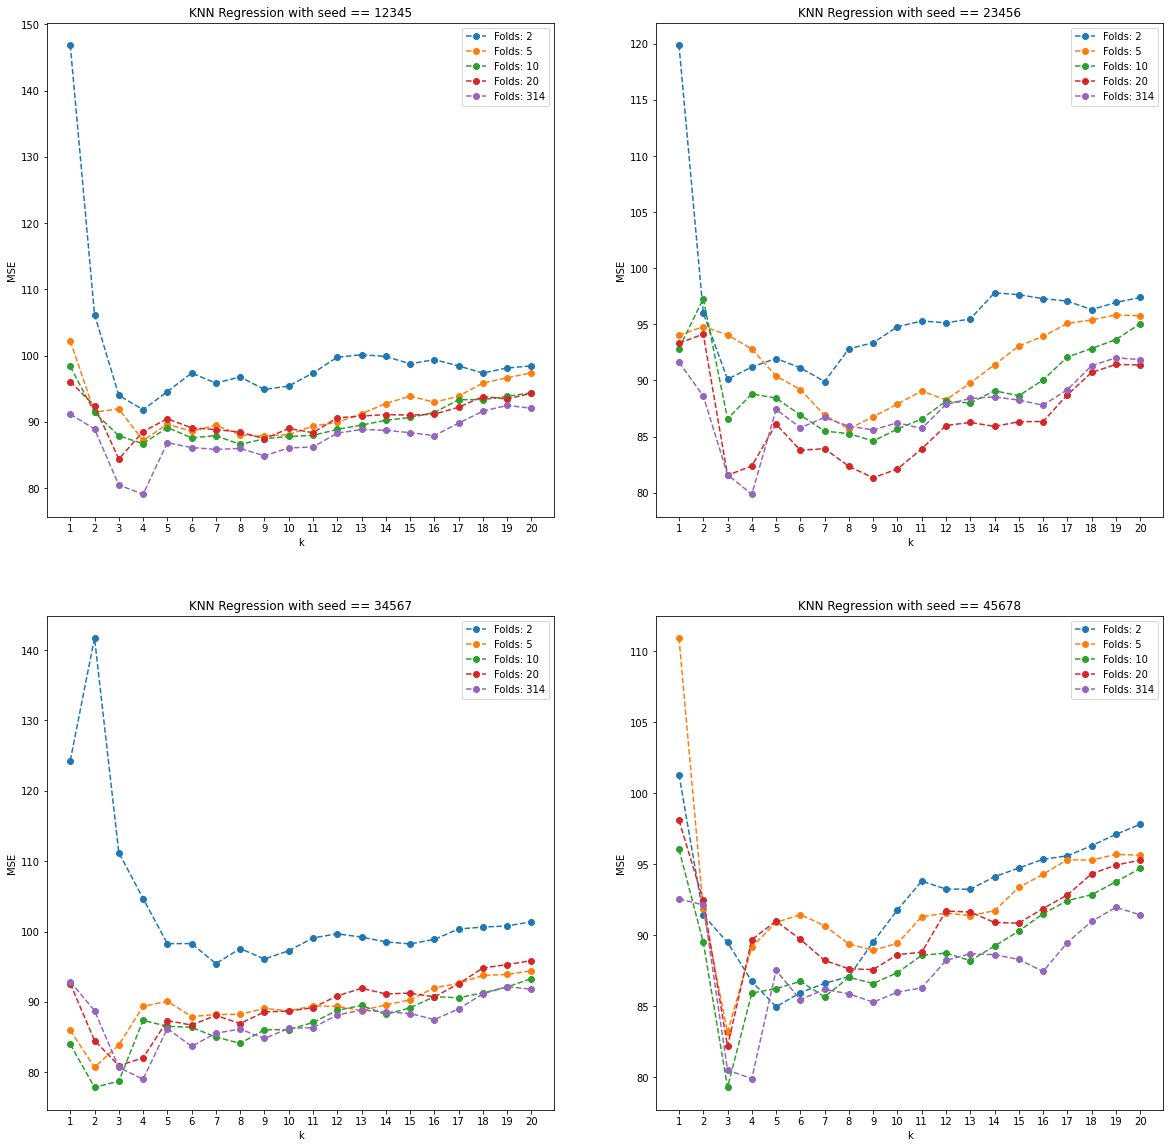

In [513]:
# 4*4 subplots
seeds = [12345, 23456, 34567, 45678]
k_folds = [2,5,10,20, len(x_train)]

knn_fold_df = pd.DataFrame([[knn_reg_kfold(x_train.to_numpy(),\
     y_train.to_numpy(), k=j, folds=i, seed=seed), i, j, seed]\
          for i in k_folds for j in k_nn for seed in seeds],\
               columns=['MSE', 'folds', 'k', 'seed'])

fig, ax = plt.subplots(2, 2, figsize=(20, 20))
seed_index = 0
for i in range(2):
     for j in range(2):
          for k in k_folds:
               seed = seeds[seed_index]
               knn_fold_df.query("folds == @k and seed == @seed").plot(
                    x='k', y='MSE', kind='line', label='Folds: {}'.format(k), ax=ax[i, j], 
                    style="o--"
               )
               ax[i, j].set_xlabel("k")
               ax[i, j].set_ylabel("MSE")
               ax[i, j].set_title("KNN Regression with seed == {}".format(seed))
               ax[i, j].set_xticks(range(1, 21))
          seed_index += 1

We have tried 4 different seeds and we can see that the relationship between k-nearest neighbors and the expected MSE across the selected 5 different folds generally follows the same trend, despite some variations for 2-folds cv. Even though higher number of folds do not always give us a lower expected MSE, an increase in folds in general give us a lower and more stable expected MSE compared to lower number of folds. For all 4 seeds, the lowest expected MSE is achieved around $K=4$ nearest neighbors across all folds of cv (on average).

### Part 5

Using the above information, choose a value of $K$ as the "optimal" choice.  In a few sentences, defend your choice.  You can use any heuristic you'd like to make this choice.  

Using your chosen value of $K$, create a latitude-longitude prediction map - using the training data, draw the predictions for new observations within the square created by the minimum and maximum latititudes and longitudes.  Create the same drawings for a 1-nearest neighbor regression and a 20-nearest neighbor regression.  Compare these pictures to your original plot.  How do the different choices compare to the training data?

#### Answer

As mentioned in Part 3 and 4, across all the folds and the seeds we have tried, we can notice that the expected MSE decreases very rapidly on the interval $[1, 4]$, and it in general starts to slowly increase after the $K=4$ threshold. Therefore, I think $K=4$ is our optimal choice because cross validation gives us an estimate of the model's out-of-sample performance.

In [215]:
train_lat_min = np.min(x_train['Lat'])
train_lat_max = np.max(x_train['Lat'])
train_long_min = np.min(x_train['Long'])
train_long_max = np.max(x_train['Long'])
train_lat_diff = train_lat_max - train_lat_min
train_long_diff = train_long_max - train_long_min
print("In the training data, Lat_min: {}, Lat_max: {}, Long_min: {}, Long_max: {}.\n\
Lat difference: {}, Long difference: {}".format(
    train_lat_min, train_lat_max, train_long_min, train_long_max, train_lat_diff, train_long_diff
))


In the training data, Lat_min: 24.94883, Lat_max: 24.99176, Long_min: 121.51151, Long_max: 121.55481.
Lat difference: 0.04292999999999836, Long difference: 0.043300000000002115


In [273]:
np.random.seed(777)
lat = np.linspace(train_lat_min + (train_lat_diff / 150)*np.random.normal(0,1,1),
    train_lat_max + (train_lat_diff / 150)*np.random.normal(0,1,1), 150
)

long = np.linspace(train_long_min + (train_long_diff / 150)*np.random.normal(0,1,1),
    train_long_max + (train_long_diff / 150)*np.random.normal(0,1,1), 150
)

LAT, LONG = np.meshgrid(lat, long)

In [274]:
LAT.shape
x_train_map = np.hstack([LAT.ravel().reshape(-1, 1), LONG.ravel().reshape(-1, 1)])

(24.946554573199002, 24.993665932970956, 121.50933547948148, 121.5567597236536)

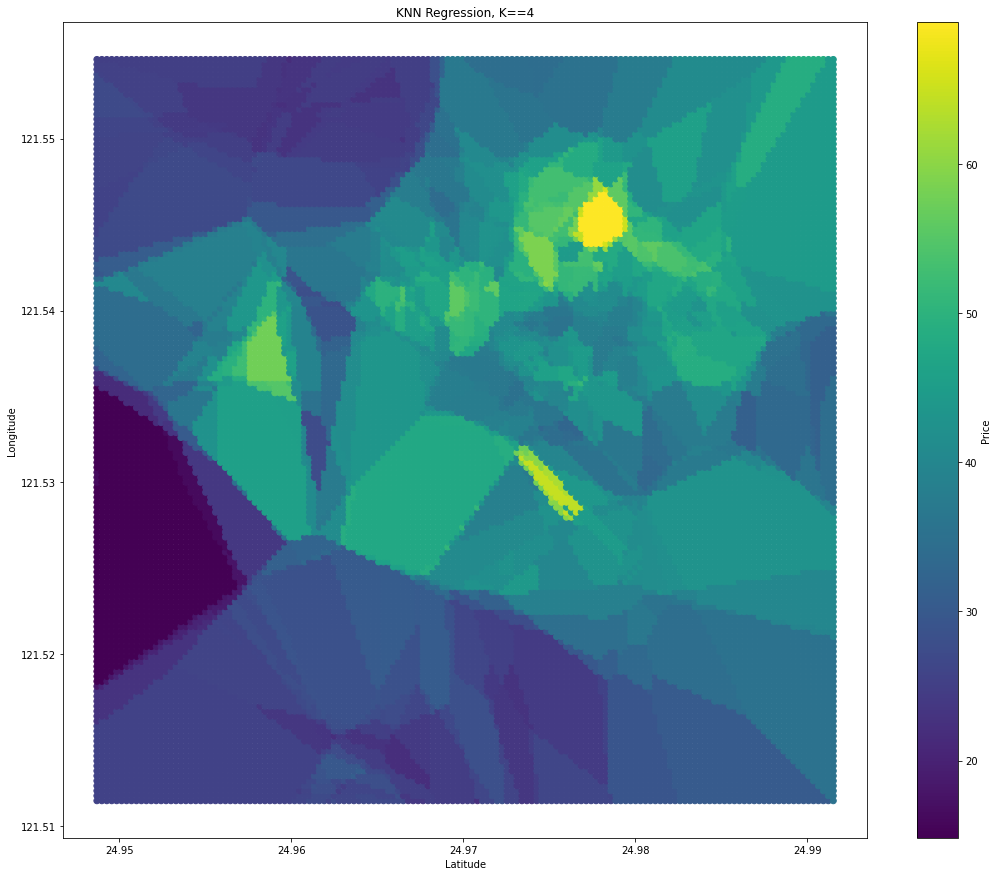

In [293]:
knn_reg = KNeighborsRegressor(n_neighbors=4)
knn_reg.fit(x_train.to_numpy(), y_train.to_numpy())
y_pred_map = knn_reg.predict(x_train_map)

fig, ax = plt.subplots(figsize=(18, 15))
fig.colorbar(ax.scatter(x=LAT.ravel(), y=LONG.ravel(), c=y_pred_map), ax=ax, label="Price")
ax.ticklabel_format(useOffset=False)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_title('KNN Regression, K==4')
ax.axis('equal')

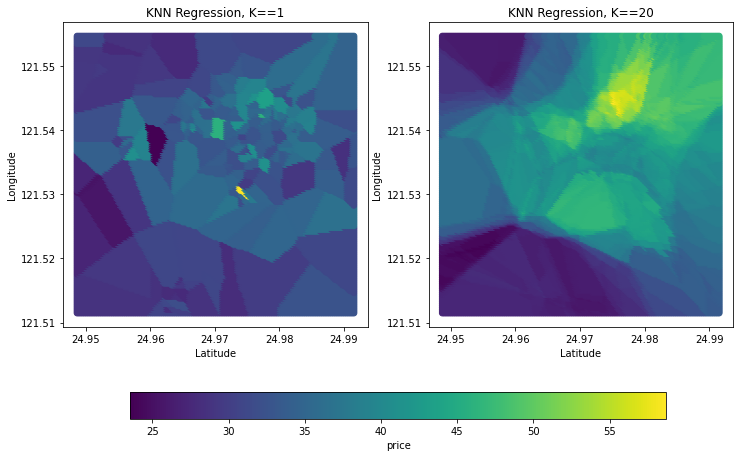

In [320]:
knn_reg_1 = KNeighborsRegressor(n_neighbors=1)
knn_reg_1.fit(x_train.to_numpy(), y_train.to_numpy())
y_pred_map_1 = knn_reg_1.predict(x_train_map)

knn_reg_20 = KNeighborsRegressor(n_neighbors=20)
knn_reg_20.fit(x_train.to_numpy(), y_train.to_numpy())
y_pred_map_20 = knn_reg_20.predict(x_train_map)

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
for i in range(0,2):
    ax[i].ticklabel_format(useOffset=False)
    ax[i].set_xlabel('Latitude')
    ax[i].set_ylabel('Longitude')

ax[0].set_title('KNN Regression, K==1')
ax[1].set_title('KNN Regression, K==20')
plots = ax[0].scatter(x=LAT.ravel(), y=LONG.ravel(), c=y_pred_map_1)
plots = ax[1].scatter(x=LAT.ravel(), y=LONG.ravel(), c=y_pred_map_20)
fig.colorbar(plots, ax=ax, location= "bottom", shrink = 0.8, label = "price")


We can see that lower $K$ for K-nearest neighbors tend to create more small local regions that have distinct predictions of property price, which makes sense because smaller $K$ implies a more complex KNN model.

# Problem 2

### Part 1

We've used latitude and longitude to build a predictive model.  Let's try a different predictor - `Age`.  For the training data, plot the age of the house against the price of the house.  Is this relationship linear?  Polynomial?  What degree of polynomial do you think best describes the relationship?  In a sentence or two, logically explain why this perceived relationship might hold.

Text(0.5, 1.0, 'Age vs Price')

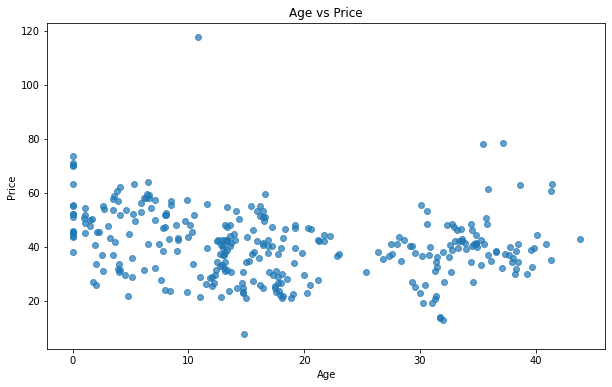

In [329]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x=train_df['Age'], y=train_df['Price'], marker='o', alpha=0.7)
ax.set_xlabel('Age')
ax.set_ylabel('Price')
ax.set_title('Age vs Price')


From the scatter plot alone, I think there is a negative linear relationship between `age` and `price`, if we ignore some of the data points on the top right. If these points are not outliers, then the relationship can be quadratic.

### Part 2

Find the degree of polynomial that maximizes the expected prediction error using the training data.  That is compare $y_i = \alpha + \epsilon_i$ vs. $y_i = \alpha + \beta_1 x_i + \epsilon_i$ vs. $y_i = \alpha + \beta_1 x_i + \beta_2 x_i^2 + \epsilon_i$ and so on.

Since the linear model is algebraically "easy"^[I say with the most sarcastic quotes of all time.  Really I just mean that it's analytically tractible to do a lot of things.], let's use the wealth of non-simulation based estimates of the expected prediction error to make this decision.  Write a function called `lm_pred_metrics` that takes in either a fit linear regression model **or** the $N \times P + 1$ matrix of predictors (with the first column being a column of 1s to capture the intercept) and a $N$-vector of outcomes.  The function should compute:

  1. The AIC
  
  2. The BIC
  
  3. The leave-one-out cross validation estimate of the expected prediction error
  
  4. The generalized cross validation estimate of the expected prediction error
  
You should compute the regression coefficients and estimate of $\sigma^2$ using a pre-built linear regression function and extract these.  For LOOCV, you'll also need the hat/influence matrix.  For GCV (under linear regression), you can avoid using the hat matrix if you pick up on the trace trick in the hints.  Your chosen regression implementation will also likely return residuals, $\hat{\boldsymbol{y}}$, and many other meaningful metrics of fit.  

In [452]:
import statsmodels.api as sm
x_train = train_df[['Lat', 'Long', 'Age']].copy()
y_train = train_df['Price'].copy() 
x_train['intercept'] = 1.0 # append a column of ones to x_train for the intercept
x_train = x_train[['intercept', 'Lat', 'Long', 'Age']]
ols_reg = sm.OLS(y_train.to_numpy(), x_train.to_numpy())
ols_reg_result = ols_reg.fit()
print(ols_reg_result.summary())
# extract sigma square
sigma_square = ols_reg_result.mse_resid
num_params = ols_reg_result.df_model


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     53.22
Date:                Mon, 07 Feb 2022   Prob (F-statistic):           8.97e-28
Time:                        04:04:19   Log-Likelihood:                -1174.0
No. Observations:                 314   AIC:                             2356.
Df Residuals:                     310   BIC:                             2371.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.398e+04   6945.906     -9.211      0.0

In [382]:
# manually calculate hat matrix diag vs. hat matrix diag from statsmodels
hat_matrix = (x_train.to_numpy() @ np.linalg.inv(x_train.to_numpy().T @ x_train.to_numpy()) @ x_train.to_numpy().T)
np.linalg.norm(hat_matrix.diagonal() - \
ols_reg_result.get_influence().summary_frame()['hat_diag'])
# norm is decently close to zero, the difference could be due to the inverse calculation

3.55756851127842e-09

In [383]:
hat_matrix.shape

(314, 314)

In [375]:
# built-in function to retrieve hat matrix diag
ols_reg_result.get_influence().summary_frame()

,dfb_const,dfb_x1,dfb_x2,dfb_x3,cooks_d,standard_resid,hat_diag,dffits_internal,student_resid,dffits
0,-0.006290,-0.003927,0.007213,-0.019447,0.000166,0.256373,0.009997,0.025763,0.255986,0.025724
1,-0.011108,-0.006936,0.012739,-0.034345,0.000517,0.452678,0.009997,0.045489,0.452097,0.045431
2,0.005484,-0.140076,0.025971,-0.114489,0.012225,1.937142,0.012864,0.221135,1.945828,0.222127
3,0.005492,-0.134114,0.024623,-0.105736,0.010960,1.850062,0.012646,0.209377,1.857358,0.210203
4,0.009586,-0.122743,0.017947,-0.092071,0.008642,1.581573,0.013631,0.185922,1.585429,0.186375
...,...,...,...,...,...,...,...,...,...,...
309,0.037909,-0.010763,-0.035717,0.007592,0.000430,0.265866,0.023772,0.041488,0.265467,0.041426
310,-0.035148,0.009862,0.033142,-0.005876,0.000368,-0.247142,0.023527,-0.038362,-0.246768,-0.038304
311,-0.050167,0.019808,0.046013,0.012198,0.000864,-0.374637,0.024033,-0.058790,-0.374117,-0.058708
312,0.058961,-0.019252,-0.054986,0.004520,0.001041,0.411528,0.024005,0.064539,0.410976,0.064452


In [453]:
def lm_pred_metrics(**kwargs):
    if 'fit_model' in kwargs:
        fit_model = kwargs['fit_model']
        x_train = fit_model.exog
        y_train = fit_model.endog
    elif 'x_train' in kwargs and 'y_train' in kwargs:
        x_train = kwargs['x_train']
        y_train = kwargs['y_train']
        fit_model = sm.OLS(y_train, x_train)
    else:
        raise Exception('No fit model or x_train and y_train provided')

    fit_model_result = fit_model.fit()
    sigma_square = fit_model_result.mse_resid
    beta_coef = fit_model_result.params
    y_predict = x_train.dot(beta_coef)
    nobvs = x_train.shape[0]
    
    # Log-likelihood
    log_likelihood = -(nobvs/2) * (np.log(2*np.pi) + np.log(sigma_square)) - 1/(2*sigma_square) * np.sum((y_train - y_predict)**2)
    # Akaike Information Criterion (AIC)
    aic = -2 * log_likelihood + 2 * fit_model_result.df_model
    # Bayesian Information Criterion (BIC)
    bic = -2 * log_likelihood + np.log(nobvs) * fit_model_result.df_model
    # LOOCV Estimate
    try:
        if kwargs['use_builtIn_hatMatrix'] == True:
            hat_diag = fit_model_result.get_influence().summary_frame()['hat_diag']
        else:
            raise Exception('use_builtIn_hatMatrix is False')
    except:
        hat_matrix = x_train @ np.linalg.inv(x_train.T @ x_train) @ x_train.T
        hat_diag = hat_matrix.diagonal()

    loocv_estimate = 1/nobvs * np.sum(
        ((y_train - y_predict)/(np.ones(nobvs) - hat_diag)) ** 2
    )
    # GCV Estimate
    hat_trace = np.sum(hat_diag)
    gcv_estimate = 1/nobvs * np.sum(
        ((y_train - y_predict)/(1 - (hat_trace/nobvs))) ** 2
    )

    return {
        'log_likelihood': log_likelihood,
        'aic': aic,
        'bic': bic,
        'loocv_estimate': loocv_estimate,
        'gcv_estimate': gcv_estimate,
    }

# test with a fit model
print(lm_pred_metrics(fit_model=ols_reg, use_builtIn_hatMatrix=True))
lm_pred_metrics(x_train=x_train.to_numpy(), y_train=y_train.to_numpy(), use_builtIn_hatMatrix=False)

{'log_likelihood': -1173.9901813733384, 'aic': 2353.9803627466767, 'bic': 2365.2285417044013, 'loocv_estimate': 106.09410207747761, 'gcv_estimate': 106.2003009777224}


{'log_likelihood': -1173.9901813733384,
 'aic': 2353.9803627466767,
 'bic': 2365.2285417044013,
 'loocv_estimate': 106.09410207096842,
 'gcv_estimate': 106.20030097834764}

### Part 3

Using your function above, compute the various metrics of generalizability for all polynomial models of order 1 through 10 (the third order polynomial model would be $y_i = \alpha + \beta_1 x_{i} + \beta_2 x_{i}^2 + \beta_3 x_i^3 + \epsilon_i$, for example).  Plot each metric against degree of the basis expansion.  Which of the models minimizes the generalization error?  Is this conclusion consistent across metrics?  Would we expect $K$-fold cross validation to produce a similar conclusion?  What does this say about predictive model selection for standard linear regression models?

Create a plot that shows the predicted values granted by the optimal model for any age that's within the set of ages in the training set and compare it to the observed data in the training data.  Does it look right on the entire training data?  A little underfit?  A little overfit?

Remember the degree of the model as the optimal Age model.

In [468]:
# Assume only use `Age` as the predictor
poly_fit_metrics_df = pd.DataFrame(columns=['degree', 'aic', 'bic', 'loocv_estimate', 'gcv_estimate'])
for degree in range(1,11):
    x_train = train_df[['Age']].copy()
    x_train['intercept'] = 1.0 # append a column of ones to x_train for the intercept
    x_train = x_train[['intercept', 'Age']]
    y_train = train_df['Price'].copy()

    if degree != 1:
        for i in range(2, degree+1):
            x_train['Age^'+str(i)] = x_train['Age'].apply(lambda x: x**i)
    
    ols_reg = sm.OLS(y_train.to_numpy(), x_train.to_numpy())
    metrics = lm_pred_metrics(fit_model=ols_reg, use_builtIn_hatMatrix=True)
    metrics['degree'] = degree
    metrics.pop('log_likelihood') # remove log_likelihood
    poly_fit_metrics_df = poly_fit_metrics_df.append(metrics, ignore_index=True)

In [469]:
poly_fit_metrics_df

,degree,aic,bic,loocv_estimate,gcv_estimate
0,1.0,2466.217941,2469.967334,151.858831,151.822184
1,2.0,2432.953483,2440.452269,136.453580,136.564604
2,3.0,2434.727916,2445.976095,137.202653,137.343454
3,4.0,2436.392958,2451.390530,137.888762,138.080072
4,5.0,2437.889242,2456.636207,138.294934,138.747504
5,6.0,2439.091247,2461.587605,139.478109,139.289030
6,7.0,2438.242985,2464.488735,138.657939,138.924077
7,8.0,2434.036396,2464.031540,156.744346,137.087488
8,9.0,2433.815759,2463.810902,208.827291,137.893319
9,10.0,2782.770313,2809.016064,460.340948,416.193863


Text(0, 0.5, 'metric')

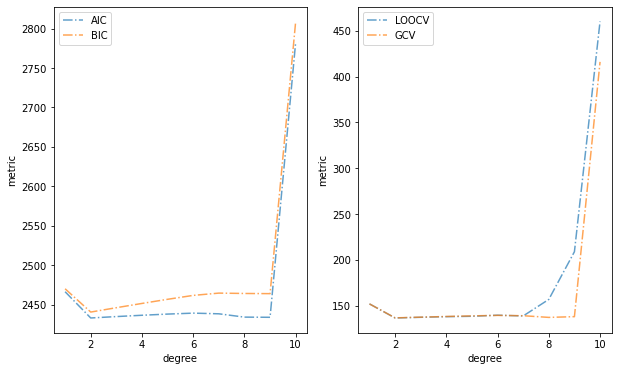

In [470]:
fig, ax = plt.subplots(1,2, figsize=(10, 6))
ax[0].plot(poly_fit_metrics_df['degree'], poly_fit_metrics_df['aic'], ls='dashdot', alpha=0.7)
ax[0].plot(poly_fit_metrics_df['degree'], poly_fit_metrics_df['bic'], ls='dashdot', alpha=0.7)
ax[1].plot(poly_fit_metrics_df['degree'], poly_fit_metrics_df['loocv_estimate'], ls='dashdot', alpha=0.7)
ax[1].plot(poly_fit_metrics_df['degree'], poly_fit_metrics_df['gcv_estimate'], ls='dashdot', alpha=0.7)
ax[0].set_xlabel('degree')
ax[0].set_ylabel('metric')
ax[0].legend(['AIC', 'BIC'])
ax[1].legend(['LOOCV', 'GCV'])
ax[1].set_xlabel('degree')
ax[1].set_ylabel('metric')


In [471]:
poly_fit_metrics_df.diff().assign(degree=poly_fit_metrics_df['degree'])
# shifted difference

,degree,aic,bic,loocv_estimate,gcv_estimate
0,1.0,NaN,NaN,NaN,NaN
1,2.0,-33.264458,-29.515065,-15.405251,-15.257580
2,3.0,1.774433,5.523826,0.749073,0.778850
3,4.0,1.665043,5.414436,0.686109,0.736617
4,5.0,1.496284,5.245677,0.406172,0.667432
5,6.0,1.202005,4.951398,1.183174,0.541526
6,7.0,-0.848262,2.901131,-0.820169,-0.364952
7,8.0,-4.206588,-0.457195,18.086407,-1.836590
8,9.0,-0.220638,-0.220638,52.082945,0.805831
9,10.0,348.954554,345.205161,251.513656,278.300543


In [486]:
# subtract the second row from all rows
poly_fit_metrics_df.subtract(poly_fit_metrics_df.iloc[1]).assign(degree=poly_fit_metrics_df['degree'])

,degree,aic,bic,loocv_estimate,gcv_estimate
0,1.0,33.264458,29.515065,15.405251,15.257580
1,2.0,0.000000,0.000000,0.000000,0.000000
2,3.0,1.774433,5.523826,0.749073,0.778850
3,4.0,3.439475,10.938261,1.435182,1.515467
4,5.0,4.935760,16.183938,1.841354,2.182900
5,6.0,6.137764,21.135336,3.024528,2.724425
6,7.0,5.289502,24.036467,2.204359,2.359473
7,8.0,1.082914,23.579272,20.290766,0.522884
8,9.0,0.862276,23.358634,72.373711,1.328715
9,10.0,349.816830,368.563795,323.887367,279.629258


Based on the plot and table, I think the degree of the polynomial model that minimizes the generalization error is 2. A k-fold cross validation with relatively high values of $K$ would produce similar results. From this experiment, I think higher degree polynomial models are not necessarily better and usually perform worse than models with lower degree. However, this is highly dependent on the distribution of the data.

In [456]:
poly_fit_df = pd.DataFrame(columns=['degree', 'y_predict'])
for degree in range(1,11):
    x_train = train_df[['Age']].copy()
    x_train['intercept'] = 1.0 # append a column of ones to x_train for the intercept
    x_train = x_train[['intercept', 'Age']]
    y_train = train_df['Price'].copy()

    if degree != 1:
        for i in range(2, degree+1):
            x_train['Age^'+str(i)] = x_train['Age'].apply(lambda x: x**i)
    
    poly_reg = sm.OLS(y_train.to_numpy(), x_train.to_numpy())
    y_predict = poly_reg.fit().predict(x_train.to_numpy())
    poly_fit_df = poly_fit_df.append({'degree': degree, 'y_predict': y_predict}, ignore_index=True)

poly_fit_df.head()


,degree,y_predict
0,1,"[44.195086392863914, 44.195086392863914, 43.75..."
1,2,"[50.03956989519159, 50.03956989519159, 47.4614..."
2,3,"[49.77152002626617, 49.77152002626617, 47.4523..."
3,4,"[49.63491012515748, 49.63491012515748, 47.7667..."
4,5,"[49.48873418179257, 49.48873418179257, 47.2040..."


In [458]:
poly_fit_df = poly_fit_df.explode('y_predict')
poly_fit_df

,degree,y_predict
0,1,44.195086
0,1,44.195086
0,1,43.757853
0,1,43.670406
0,1,43.757853
...,...,...
9,10,42.652768
9,10,42.248949
9,10,56.015103
9,10,35.921618


Text(0, 0.5, 'Price')

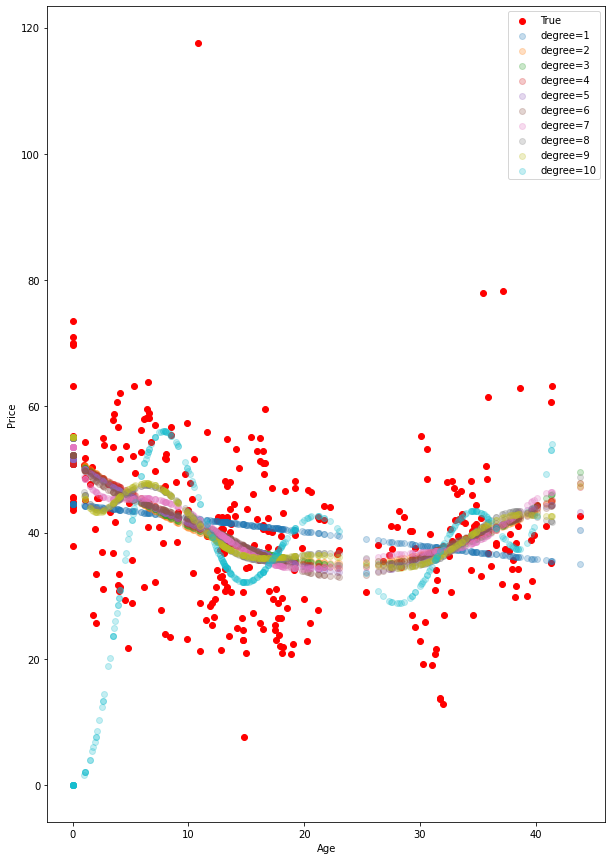

In [494]:
fig, ax = plt.subplots(figsize=(10, 15))
ax.scatter(train_df['Age'], train_df['Price'], c='red', label='True')
for i in range(1,11):
    ax.scatter(train_df['Age'], poly_fit_df[poly_fit_df['degree'] == i]['y_predict'], label='degree='+str(i), alpha=0.25)
ax.legend()
ax.set_xlabel('Age')
ax.set_ylabel('Price')


We can see that the predicted pricing by 10-degree polynomial model has many oscillations compared to others, so the 10-degree model is obviously overfitting. Similarly, the 1st-degree model seems to be underfitting.

# Problem 3

Using the tools you've already developed, come up with a good predictive model for the relationship between distance to nearest metro station (`DisttoMRT`), number of convenience stores in the walking radius (`NumConvStores`), and house price (`Price`).  You should use $K$-nearest neighbors or linear regression as your predictive model.  Using the methods we've discussed for quantifying generalization error, argue that your model is optimal in some sense of out-of-sample generalization.

In [495]:
train_df

,ID,Date,Age,DisttoMRT,NumConvStores,Lat,Long,Price,Year,Month
0,20,2012.666667,1.5,23.38284,7,24.96772,121.54102,47.7,2012,9
1,276,2012.666667,1.5,23.38284,7,24.96772,121.54102,49.7,2012,9
2,161,2012.916667,3.5,49.66105,8,24.95836,121.53756,57.8,2012,12
3,378,2013.333333,3.9,49.66105,8,24.95836,121.53756,56.8,2013,5
4,58,2012.916667,3.5,56.47425,7,24.95744,121.53711,53.5,2012,12
...,...,...,...,...,...,...,...,...,...,...
309,278,2013.416667,21.2,2185.12800,3,24.96322,121.51237,27.7,2013,6
310,370,2012.666667,20.2,2185.12800,3,24.96322,121.51237,22.8,2012,9
311,235,2013.250000,8.0,2216.61200,4,24.96007,121.51361,23.9,2013,4
312,366,2012.916667,17.3,2261.43200,4,24.96182,121.51222,29.5,2012,12


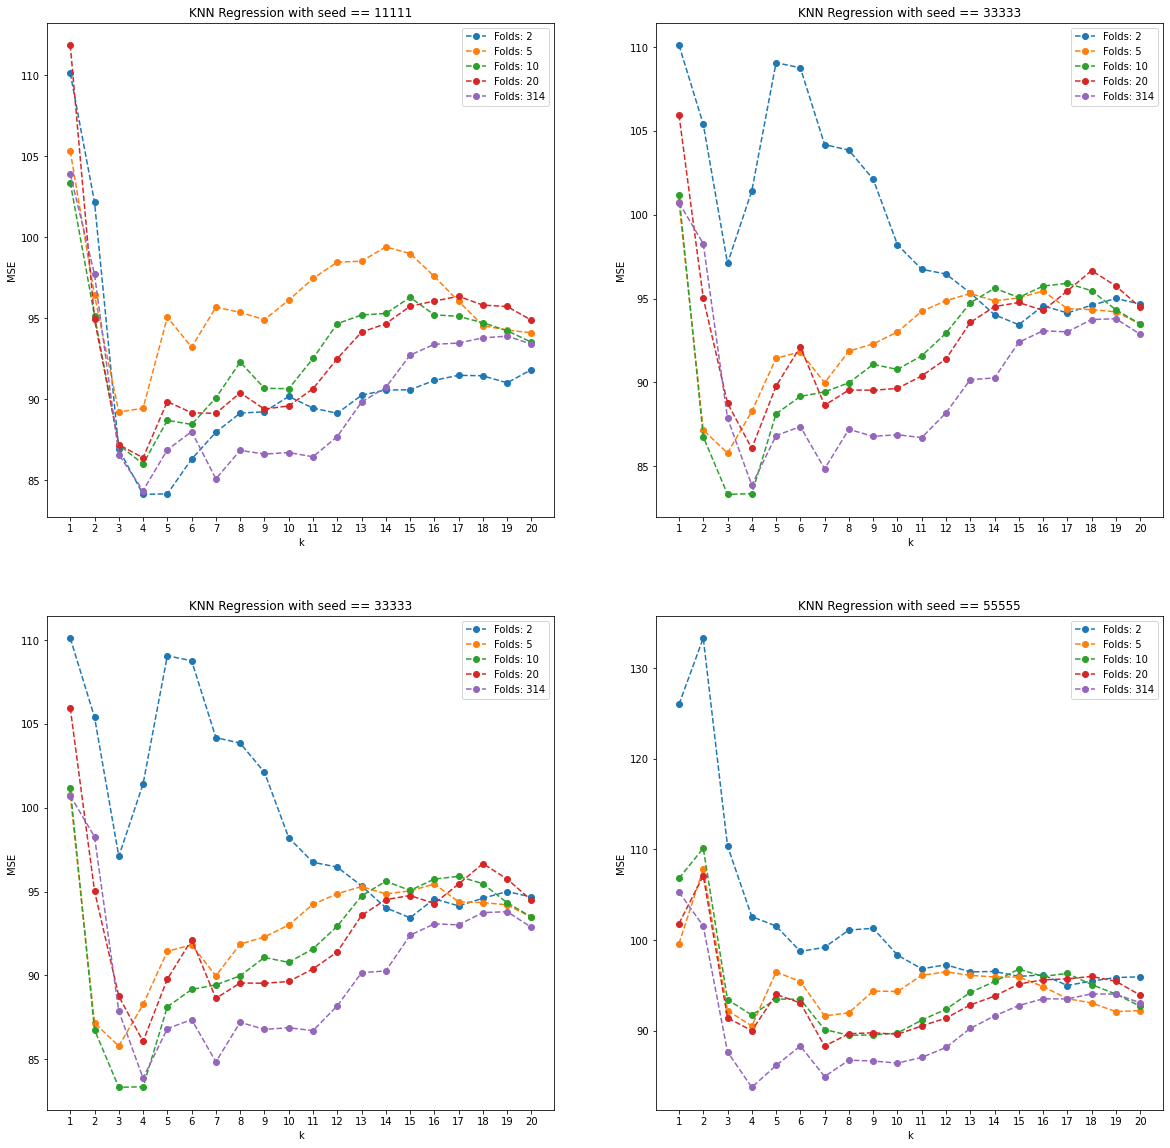

In [514]:
x_train = train_df[['DisttoMRT', 'NumConvStores']].copy()
y_train = train_df['Price'].copy()
# feature standardization bc DisttoMRT and NumConvStore in different scales
# I think because knn depends on the 'distance' between the points so I think it should be standardized
# but I'm not 100% sure
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

seeds = [11111, 33333, 55555, 77777]
k_folds = [2,5,10,20, len(x_train)]

knn_fold_df = pd.DataFrame([[knn_reg_kfold(x_train,\
     y_train.to_numpy(), k=j, folds=i, seed=seed), i, j, seed]\
          for i in k_folds for j in k_nn for seed in seeds],\
               columns=['MSE', 'folds', 'k', 'seed'])

fig, ax = plt.subplots(2, 2, figsize=(20, 20))

for i in range(2):
     for j in range(2):
          for k in k_folds:
               seed = seeds[i+j]
               knn_fold_df.query("folds == @k and seed == @seed").plot(
                    x='k', y='MSE', kind='line', label='Folds: {}'.format(k), ax=ax[i, j], 
                    style="o--"
               )
               ax[i, j].set_xlabel("k")
               ax[i, j].set_ylabel("MSE")
               ax[i, j].set_title("KNN Regression with seed == {}".format(seed))
               ax[i, j].set_xticks(range(1, 21))

In [520]:
knn_fold_df.query("folds == 314 and k == 4").assign(
    MSE_MEAN = knn_fold_df.query("folds == 314 and k == 4")['MSE'].mean()
)

,MSE,folds,k,seed,MSE_MEAN
332,84.347418,314,4,11111,84.067681
333,83.867566,314,4,33333,84.067681
334,83.767277,314,4,55555,84.067681
335,84.288463,314,4,77777,84.067681


I think the model is optimal when $K =4$ for K-nearest neighbors because we can see that the expected estimate of out-of-sample prediction error is minimized when $K=4$ across all folds. The model has an an expected MSE of $84.067681$.

# Problem 4

### Part 1

You've found 3 "optimal" models for predicting the price of a home - one that looks at location, one that looks at age, and one that looks at features surrounding the home.  Compare the LOOCV estimate of the expected prediction error across the three models.  Which one performs best?

Obviously, we could probably do better if we used all of the predictors in one model.  But, each model that we've tested is *cohesive* - we're examining the predictive power of different sets of real estate covariates.

Alas, we've judged out-of-sample predictive power without actually ever using an out-of-sample data set - a.k.a. the "original sin".  Fortunately, your gracious teacher has held out some test sets for you.  Using the models you declared optimal in the previous steps, assess the mean squared prediction error for each model on the two holdout data sets.

Does the same ranking of models hold for each test set in terms of average predictive accuracy?  Are the estimates produced by the various methods close to the average prediction errors in the test sets?

In [527]:
quad_reg_loocv = poly_fit_metrics_df.loc[poly_fit_metrics_df['degree'] == 2]['loocv_estimate'].values[0]
# seed = 77777
knn_distConv_loocv = knn_fold_df.query("folds == 314 and k == 4 and seed == 77777")['MSE'].values[0]

x_train = train_df[['Lat', 'Long']].copy()
y_train = train_df['Price'].copy()
knn_location_loocv = knn_reg_kfold(x_train.to_numpy(), y_train.to_numpy(), k=4, folds=314, seed=77777)

print("Linear Regression with `Age` LOOCV: {},\nKNN Regression with `DisttoMRT` and `NumConvStores` LOOCV: {},\nKNN Regression with `Lat` and `Long` LOOCV: {}".format(
    quad_reg_loocv,
    knn_distConv_loocv,
    knn_location_loocv
))


Linear Regression with `Age` LOOCV: 136.45358028738494,
KNN Regression with `DisttoMRT` and `NumConvStores` LOOCV: 84.28846337579617,
KNN Regression with `Lat` and `Long` LOOCV: 77.78151472929936


The expected prediction error is the lowest for the KNN model with latitude and longitude features.
The linear regression model has the highest expected prediction error.

### TEST SET 1

#### Degree 2 Linear Regression:

In [558]:
# TEST SETS
test_df_1 = pd.read_csv('TaiwanPricing_Test1.csv')
# train set
x_train = train_df[['Age']].copy()
x_train['intercept'] = 1.0 # append a column of ones to x_train for the intercept
x_train = x_train[['intercept', 'Age']]
x_train['Age^2'] = x_train['Age'].apply(lambda x: x**2)
y_train = train_df['Price'].copy()
poly_reg = sm.OLS(y_train.to_numpy(), x_train.to_numpy())

# test set
x_test = test_df_1[['Age']].copy()
x_test['intercept'] = 1.0 # append a column of ones to x_train for the intercept
x_test = x_test[['intercept', 'Age']]
x_test['Age^2'] = x_test['Age'].apply(lambda x: x**2)
y_test = test_df_1['Price'].copy()
y_predict = poly_reg.fit().predict(x_test.to_numpy())
print("MSE: {}".format(get_MSE(y_test, y_predict)))
print("LOOCV Estimate: {}".format(quad_reg_loocv))

MSE: 333.138812351977
LOOCV Estimate: 136.45358028738494


#### KNN, Latitude and Longitude:

In [559]:
# test set
x_train = train_df[['Lat', 'Long']].copy()
y_train = train_df['Price'].copy()
knn_reg_location = KNeighborsRegressor(n_neighbors=4)
knn_reg_location.fit(x_train.to_numpy(), y_train.to_numpy())
# test set
x_test = test_df_1[['Lat', 'Long']].copy()
y_test = test_df_1['Price'].copy()
y_predict = knn_reg_location.predict(x_test.to_numpy())
print("MSE: {}".format(get_MSE(y_test, y_predict)))
print("LOOCV Estimate: {}".format(knn_location_loocv))

MSE: 96.417175
LOOCV Estimate: 77.78151472929936


#### KNN, Distance to MRT and Number of Convenience Stores:

In [560]:
# test set
x_train = train_df[['DisttoMRT', 'NumConvStores']].copy()
y_train = train_df['Price'].copy()

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
knn_reg_location = KNeighborsRegressor(n_neighbors=4)
knn_reg_location.fit(x_train, y_train.to_numpy())
# test set
x_test = test_df_1[['DisttoMRT', 'NumConvStores']].copy()
x_test = scaler.transform(x_test) # feature standardization
y_test = test_df_1['Price'].copy()
y_predict = knn_reg_location.predict(x_test)
print("MSE: {}".format(get_MSE(y_test, y_predict)))
print("LOOCV Estimate: {}".format(knn_distConv_loocv))

MSE: 94.524475
LOOCV Estimate: 84.28846337579617


### TEST SET 2

#### Degree 2 Linear Regression:

In [561]:
# TEST SETS
test_df_2 = pd.read_csv('TaiwanPricing_Test2.csv')
# train set
x_train = train_df[['Age']].copy()
x_train['intercept'] = 1.0 # append a column of ones to x_train for the intercept
x_train = x_train[['intercept', 'Age']]
x_train['Age^2'] = x_train['Age'].apply(lambda x: x**2)
y_train = train_df['Price'].copy()
poly_reg = sm.OLS(y_train.to_numpy(), x_train.to_numpy())

# test set
x_test = test_df_2[['Age']].copy()
x_test['intercept'] = 1.0 # append a column of ones to x_train for the intercept
x_test = x_test[['intercept', 'Age']]
x_test['Age^2'] = x_test['Age'].apply(lambda x: x**2)
y_test = test_df_2['Price'].copy()
y_predict = poly_reg.fit().predict(x_test.to_numpy())
print("MSE: {}".format(get_MSE(y_test, y_predict)))
print("LOOCV Estimate: {}".format(quad_reg_loocv))

MSE: 105.82630459960008
LOOCV Estimate: 136.45358028738494


#### KNN, Latitude and Longitude:

In [562]:
# test set
x_train = train_df[['Lat', 'Long']].copy()
y_train = train_df['Price'].copy()
knn_reg_location = KNeighborsRegressor(n_neighbors=4)
knn_reg_location.fit(x_train.to_numpy(), y_train.to_numpy())
# test set
x_test = test_df_2[['Lat', 'Long']].copy()
y_test = test_df_2['Price'].copy()
y_predict = knn_reg_location.predict(x_test.to_numpy())
print("MSE: {}".format(get_MSE(y_test, y_predict)))
print("LOOCV Estimate: {}".format(knn_location_loocv))

MSE: 40.2228375
LOOCV Estimate: 77.78151472929936


#### KNN, Distance to MRT and Number of Convenience Stores:

In [563]:
# test set
x_train = train_df[['DisttoMRT', 'NumConvStores']].copy()
y_train = train_df['Price'].copy()

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
knn_reg_location = KNeighborsRegressor(n_neighbors=4)
knn_reg_location.fit(x_train, y_train.to_numpy())
# test set
x_test = test_df_2[['DisttoMRT', 'NumConvStores']].copy()
x_test = scaler.transform(x_test)
y_test = test_df_2['Price'].copy()
y_predict = knn_reg_location.predict(x_test)
print("MSE: {}".format(get_MSE(y_test, y_predict)))
print("LOOCV Estimate: {}".format(knn_distConv_loocv))

MSE: 52.944187500000005
LOOCV Estimate: 84.28846337579617


In test set 1, the test error is the lowest for the KNN model with Distance to MRT and Number of Convenience Stores features.
In test set 2, the test error is the lowest for the KNN model with latitude and longitude features.

In test set 1, the estimated prediction error is overly optimistic compared to the test error for all models. However, in test set 2, the situation is reversed – the estimated prediction errors are all higher than the test errors.

If we average the test errors across the two test sets, I think we can get a test error that is close to our prediction error estimates for all models.

### Part 2

A common phenomenon in predictive error quantification is that test sets that are truly randomly pulled from the same data generating process as the training set will overestimate the average prediction error (e.g. be a bit more pessimistic than reality).  This is due to the fact that we are optimizing predictive accuracy with respect to smaller surrogate models rather than the full caboodle of training data - even LOOCV is an average over slightly smaller submodels that results in some distance from the truth.  On the other hand, test sets that are not plausibly drawn from the same data generating process as the training data will give much higher generalization errors - we can think of this as **extrapolation error**.

Compare the training data to the two test sets.  Does this phenomenon help explain the results you just found?

At the end of the day, we're just making good educated guesses.  However, we aren't wizards.  We can't know what we haven't already seen.


In [568]:
print(
"""
Training set latitude diff(max-min): {},
Training set longitude diff(max-min): {},
Training set distance to MRT diff(max-min): {},
Training set number of stores diff(max-min): {},
Training set age diff(max-min): {},
Training set price diff(max-min): {}
""".format(
    train_df['Lat'].max() - train_df['Lat'].min(),
    train_df['Long'].max() - train_df['Long'].min(),
    train_df['DisttoMRT'].max() - train_df['DisttoMRT'].min(),
    train_df['NumConvStores'].max() - train_df['NumConvStores'].min(),
    train_df['Age'].max() - train_df['Age'].min(),
    train_df['Price'].max() - train_df['Price'].min()
))



Training set latitude diff(max-min): 0.04292999999999836,
Training set longitude diff(max-min): 0.043300000000002115,
Training set distance to MRT diff(max-min): 2252.4941599999997,
Training set number of stores diff(max-min): 10,
Training set age diff(max-min): 43.8,
Training set price diff(max-min): 109.9



In [569]:
# difference between train and test set
train_df.describe().iloc[1:,1:] - test_df_1.describe().iloc[1:,1:]

,Date,Age,DisttoMRT,NumConvStores,Lat,Long,Price,Year,Month
mean,-0.006380,-1.034382,-3289.626476,4.021911,0.020301,0.029191,19.989159,0.023822,-0.362420
std,-0.029897,5.006744,-393.017910,1.658094,-0.006294,-0.010698,4.896465,-0.013913,-0.158191
min,0.000000,-5.200000,-2264.628160,0.000000,0.016760,0.037980,-3.600000,0.000000,0.000000
25%,0.000000,-5.875000,-2987.875425,2.250000,0.023400,0.037852,16.225000,0.000000,-1.000000
50%,0.083333,-1.050000,-3629.472700,5.000000,0.024610,0.036355,21.500000,0.000000,-1.000000
75%,-0.083333,6.025000,-3503.635025,6.000000,0.023330,0.032180,24.350000,0.000000,-0.750000
max,0.000000,9.200000,-4212.144000,6.000000,-0.022830,-0.011460,70.900000,0.000000,0.000000


We can see that there is a stark difference in the data distribution of features between the training set and test set 1. For all the 6 variables used, the data in the training set is not representative of the data in the test set (data spread, mean, quantiles, etc.). This will cause extrapolation error because the model assumed the data in the training set is representative of all data, including test sets.

In [566]:
train_df.describe().iloc[1:,1:] - test_df_2.describe().iloc[1:,1:]

,Date,Age,DisttoMRT,NumConvStores,Lat,Long,Price,Year,Month
mean,0.00362,2.003618,-55.485785,0.181911,-0.000365,0.000649,1.911159,0.043822,-0.48242
std,-0.00190,1.549017,-38.819753,-0.175914,-0.001150,-0.000550,0.513821,-0.021219,0.10289
min,0.00000,0.000000,-33.091410,0.000000,0.000000,-0.000860,-8.500000,0.000000,0.00000
25%,0.06250,2.150000,-20.629950,0.250000,0.001925,0.003448,3.250000,0.000000,0.00000
50%,0.00000,-0.200000,3.356150,0.000000,-0.001460,0.000480,1.350000,0.000000,0.00000
75%,0.00000,10.750000,-103.730375,0.250000,-0.001785,0.000095,1.875000,0.000000,-1.00000
max,0.00000,1.100000,23.939000,0.000000,0.003040,0.004700,49.800000,0.000000,0.00000


For test set 2, we can see the difference is now much more subtle. Therefore, our test MSE is much lower than what we had in test set 1.